# Example: model for electricity price forecasting

In [1]:
from forecast_verifier.verifier import Verifier
from forecast_verifier.model import Forecaster
from forecast_verifier.graph import EffectDirection, PerturbationDirection
from forecast_verifier.utils import load_model
import numpy as np
import pandas as pd
import os
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

## LASSO-enhanced autoregressive (LEAR) model

In [2]:
class CustomModel(Forecaster):
    
    def __init__(self, model_path: str):        
        self.next_day = model_path.strip(
            './saved_models/LEAR/LEAR_CW730_')[:10]
        self.model = load_model(model_path=model_path)
        self._unpack_model()
    
    def _unpack_model(self):
        self.model_list = self.model['models']
        self.Y_scaler = self.model['scalerY']
        self.X_scaler = self.model['scalerX']
        self.horizon = len(self.model_list)

    def forecast(self, dataset: pd.DataFrame) -> np.ndarray:
        """
        Generate forecasts for the next day (24 hours) using 24 models.

        Args:
            dataset (pd.DataFrame): Input data for forecasting.

        Returns:
            np.ndarray: Forecasted values.
        """
        X = dataset.loc[self.next_day, :].to_numpy().reshape(1, -1)
        Yp_scaled = np.zeros(self.horizon)
        for h in range(self.horizon):
            # Predicting test dataset and saving
            Yp_scaled[h] = self.model_list[h].predict(X)
        Yp = self.Y_scaler.inverse_transform(Yp_scaled.reshape(1, -1))

        return Yp

In [3]:
test_data = pd.read_csv('datasets/LEAR_Xtest.csv', parse_dates=True)
test_data.columns = [x.lower() for x in test_data.columns]
test_data.set_index('date', inplace=True)

In [4]:
perturbed_data = pd.read_csv('datasets/LEAR_Xtest_perturbed.csv', parse_dates=True)
perturbed_data.columns = [x.lower() for x in perturbed_data.columns]
perturbed_data.set_index('date', inplace=True)

# Exog3 is Load variable
# perturbed Load by Load10
# Expectation Load decreases, Predictions increases
covar = [x for x in test_data.columns if 'exog3' in x]

In [5]:
results = []
for model_path in os.listdir('saved_models/LEAR'):
    my_model = CustomModel(model_path=os.path.join('saved_models/LEAR', model_path))
    verifier_ = Verifier(my_model, test_data, perturbed_data, covar, PerturbationDirection.decreasing, EffectDirection.negative)   
    result = verifier_()['alignment_score'] 
    results.append({'model' : my_model.next_day, 'alignment_score': result})

In [6]:
result_df = pd.DataFrame(results).sort_values(by='model')
result_df

,model,alignment_score
3,2023-11-01,0.333333
1,2023-11-02,0.416667
0,2023-11-03,0.250000
5,2023-11-04,0.208333
4,2023-11-05,0.166667
2,2023-11-06,0.208333


In [7]:
pred_original = my_model.forecast(test_data) 
pred_perturbed = my_model.forecast(perturbed_data) 
(pred_original < pred_perturbed).ravel().sum()/24

np.float64(0.20833333333333334)

In [8]:
verifier_.assumption_plot()

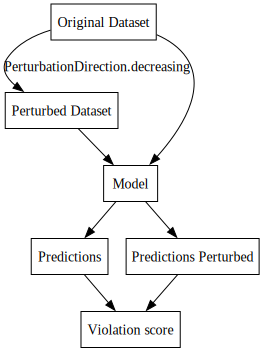

In [9]:
verifier_.procedure_plot()